In [1]:
# L'exécution de cette cellule démarre l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1692947239862_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<u>Affichage des informations sur la session en cours et liens vers Spark UI</u> :

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1692947239862_0001,pyspark,idle,Link,Link,None,✔


### 4.10.2 Installation des packages

Les packages nécessaires ont été installé via l'étape de **bootstrap** à l'instanciation du serveur.

### 4.10.3 Import des librairies

In [3]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4.10.4 Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [4]:
PATH = 's3://p8-matt-data'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://p8-matt-data
PATH_Data:   s3://p8-matt-data/Test
PATH_Result: s3://p8-matt-data/Results

### 4.10.5 Traitement des données

#### 4.10.5.1 Chargement des données

In [5]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://p8-matt-data...|2023-08-15 15:10:58|  5473|[FF D8 FF E0 00 1...|
|s3://p8-matt-data...|2023-08-15 15:11:12|  5473|[FF D8 FF E0 00 1...|
|s3://p8-matt-data...|2023-08-15 15:11:40|  5467|[FF D8 FF E0 00 1...|
|s3://p8-matt-data...|2023-08-15 15:10:57|  5465|[FF D8 FF E0 00 1...|
|s3://p8-matt-data...|2023-08-15 15:10:58|  5450|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [7]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------+--------------+
|path                                               |label         |
+---------------------------------------------------+--------------+
|s3://p8-matt-data/Test/Apple Braeburn/r_326_100.jpg|Apple Braeburn|
|s3://p8-matt-data/Test/Apple Braeburn/r_4_100.jpg  |Apple Braeburn|
|s3://p8-matt-data/Test/Apple Braeburn/r_8_100.jpg  |Apple Braeburn|
|s3://p8-matt-data/Test/Apple Braeburn/r_324_100.jpg|Apple Braeburn|
|s3://p8-matt-data/Test/Apple Braeburn/r_327_100.jpg|Apple Braeburn|
+---------------------------------------------------+--------------+
only showing top 5 rows

None

#### 4.10.5.2 Préparation du modèle

In [8]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [12]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 4.10.5.3 Définition du processus de chargement des images <br/> et application de leur featurisation à travers l'utilisation de pandas UDF

In [13]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1692689804370_0005/container_1692689804370_0005_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

#### 4.10.5.4 Exécutions des actions d'extractions de features

In [14]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://p8-matt-data/Results

In [ ]:
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4.10.6 Chargement des données enregistrées et validation du résultat

In [5]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                           features
0  s3://p8-matt-data/Test/Apple Braeburn/r_8_100.jpg  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.42206675, 0.008727...
1  s3://p8-matt-data/Test/Apple Braeburn/r_89_100...  ...  [1.4411962, 0.06184036, 0.0, 0.0, 0.014352175,...
2  s3://p8-matt-data/Test/Apple Braeburn/r_64_100...  ...  [0.6715195, 0.1485485, 0.0, 0.0, 0.0, 0.432440...
3        s3://p8-matt-data/Test/Avocado/r_44_100.jpg  ...  [0.65932703, 0.0, 0.18371835, 0.0, 0.011564936...
4        s3://p8-matt-data/Test/Avocado/r_81_100.jpg  ...  [1.4894266, 0.0, 0.23485729, 0.0, 0.0064859684...

[5 rows x 3 columns]

In [7]:
df.loc[0,'features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

In [8]:
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(473, 3)

In [9]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                           features
0  s3://p8-matt-data/Test/Apple Braeburn/r_8_100.jpg  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.42206675, 0.008727...
1  s3://p8-matt-data/Test/Apple Braeburn/r_89_100...  ...  [1.4411962, 0.06184036, 0.0, 0.0, 0.014352175,...
2  s3://p8-matt-data/Test/Apple Braeburn/r_64_100...  ...  [0.6715195, 0.1485485, 0.0, 0.0, 0.0, 0.432440...
3        s3://p8-matt-data/Test/Avocado/r_44_100.jpg  ...  [0.65932703, 0.0, 0.18371835, 0.0, 0.011564936...
4        s3://p8-matt-data/Test/Avocado/r_81_100.jpg  ...  [1.4894266, 0.0, 0.23485729, 0.0, 0.0064859684...

[5 rows x 3 columns]

## ACP

Créons d'abord un dataframe avec la colonne features

In [10]:
df_bis = spark.read.format("parquet").load(PATH_Result)
df_bis.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

In [11]:
from pyspark.ml.functions import array_to_vector

df_acp = df_bis.select("path", "label", array_to_vector("features").alias("features"))
df_acp.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)

Nous pouvons maintenant réaliser une ACP

Cherchons dans un premier temps le nombre de composantes

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

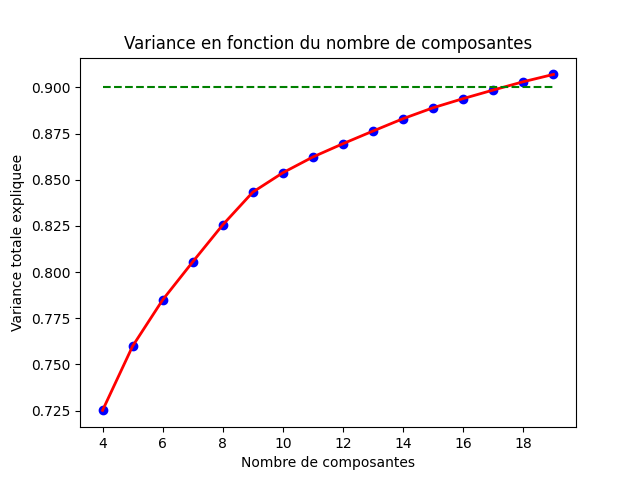

In [9]:
from pyspark.ml.feature import PCA, VectorAssembler
import matplotlib.pyplot as plt

x = range(4,20)
y = []

for i in x:
    pca = PCA(k=i, inputCol="features", outputCol="pcaFeatures")
    model = pca.fit(df_acp)
    valeurs_propres = model.explainedVariance.toArray()
    y.append(valeurs_propres.sum())

plt.scatter(x, y, color='blue', label='Points')
plt.plot(x, y, color='red', linestyle='-', linewidth=2, label='Lignes')
plt.plot([4,19],[0.9,0.9], color='green', linestyle='--')

plt.xlabel('Nombre de composantes')
plt.ylabel('Variance totale expliquee')
plt.title('Variance en fonction du nombre de composantes')
plt.show()

%matplot plt

Une valeur k de 18 sera choisie pour la suite pour obtenir au moins 90% de la variance

In [14]:
pca = PCA(k=18, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df_acp)
df_final = model.transform(df_acp)
df_final.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features|         pcaFeatures|
+--------------------+--------------+--------------------+--------------------+
|s3://p8-matt-data...|Apple Braeburn|[0.76240587234497...|[-10.719366920419...|
|s3://p8-matt-data...|Apple Braeburn|[0.58776414394378...|[-10.893703189205...|
|s3://p8-matt-data...|Apple Braeburn|[0.81906872987747...|[-11.114632919056...|
|s3://p8-matt-data...|Apple Braeburn|[1.58887314796447...|[-10.350673719946...|
|s3://p8-matt-data...|       Avocado|[0.42791247367858...|[-10.720708338009...|
|s3://p8-matt-data...|       Avocado|[0.35586899518966...|[-9.5000011569104...|
|s3://p8-matt-data...|       Avocado|[1.50026559829711...|[-9.8452297840710...|
|s3://p8-matt-data...|Apple Braeburn|[0.84507352113723...|[-12.006952478099...|
|s3://p8-matt-data...|Apple Braeburn|[0.67371851205825...|[-11.135525565090...|
|s3://p8-matt-data...|       Avocado|[1.

In [12]:
# Sauvegarde des données
PATH_final = PATH + '/ACP'
df_final.write.mode("overwrite").parquet(PATH_final)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Affichons les points selon leurs 2 premières composantes principales

In [15]:
df_final_pandas = df_final.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

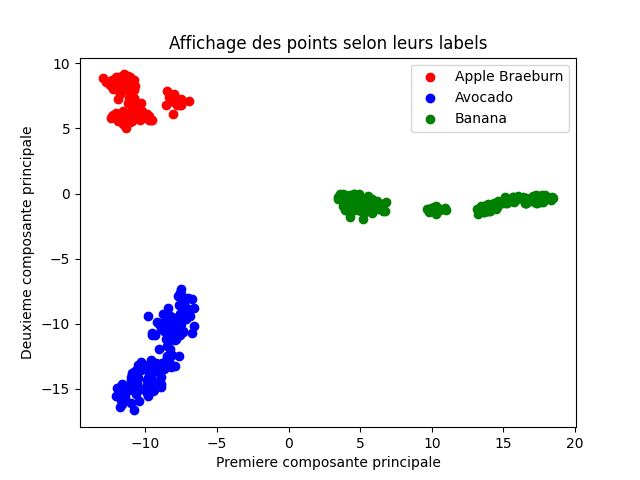

In [14]:
labels = np.unique(df_final_pandas['label'])
couleurs = {labels[0]:'red',
            labels[1]:'blue',
            labels[2]:'green'}

for l in labels:
    df_figure = df_final_pandas.loc[df_final_pandas['label']==l]
    plt.scatter([coords[0] for coords in df_figure['pcaFeatures']],
            [coords[1] for coords in df_figure['pcaFeatures']],
            label = l,
            c = couleurs[l])

plt.xlabel('Premiere composante principale')
plt.ylabel('Deuxieme composante principale')
plt.title('Affichage des points selon leurs labels')
plt.legend()
plt.show()

%matplot plt

Les 2 premières composantes principales permettent une classification visuelle des fruits

In [44]:
# Sauvegarde
path_csv = PATH + '/images_csv.csv'
df_final_pandas.to_csv(path_csv, index = False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
df_csv = pd.read_csv(path_csv)
df_csv.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                                path  ...                                        pcaFeatures
0  s3://p8-matt-data/Test/Apple Braeburn/r_40_100...  ...  [-10.719366920419695,6.690595542086449,-3.8196...
1  s3://p8-matt-data/Test/Apple Braeburn/r_46_100...  ...  [-10.8937031892051,6.1590590813925,-3.30998335...
2  s3://p8-matt-data/Test/Apple Braeburn/r_96_100...  ...  [-11.114632919056973,5.9689979790405445,-3.467...
3  s3://p8-matt-data/Test/Apple Braeburn/r_76_100...  ...  [-10.350673719946597,5.762689929365457,-2.9633...
4        s3://p8-matt-data/Test/Avocado/r_51_100.jpg  ...  [-10.720708338009453,-13.619036113087395,-4.49...

[5 rows x 4 columns]